## Exercise 5.12 - Racetrack

Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast
as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at
one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete,
a number of grid cells moved horizontally and vertically per time step.
 
The actions are increments to the velocity components. Each may be changed by +1, 0 or -1 in
each step, for a total of nine (3 x 3) actions. Both velocity components are restricted to
be non-negative and less than 5, and they cannot both be zero except at the starting line.
 
Each episode begins in one of the randomly selected start states with both velocity components zero
and ends when the car crosses the finish line. The rewards are -1 for each step until the car
crosses the finish line. If the car hits the track boundary, it is moved back to a random position
on the starting line, both velocity components are reduced to zero, and the episode continues.

Before updating the car’s location at each time step, check to see if the projected path of the
car intersects the track boundary. If it intersects the finish line, the episode ends; if it
intersects anywhere else, the car is considered to have hit the track boundary and is sent back
to the starting line. To make the task more challenging, with probability 0.1 at each time step
the velocity increments are both zero, independently of the intended increments.
 
Apply a Monte Carlo control method to this task to compute the optimal policy from each starting
state. Exhibit several trajectories following the optimal policy (but turn the noise off for these
trajectories).

In [1]:
! pip3 -q install numpy matplotlib gym

In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import racetrack
from mc import sample_episode, monte_carlo_control_eps_soft

### Racetrack Environment

c:\Program Files\Python38\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Program Files\Python38\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Program Files\Python38\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
c:\Program Files\Python38\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written

Episode 0/1000: #updates=17 return=-17.0


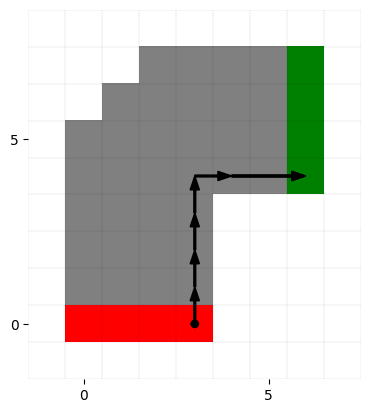

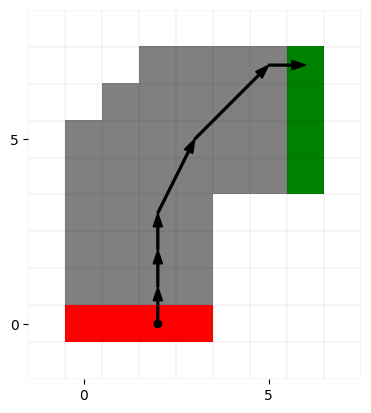

In [2]:
env = gym.make('Racetrack-v0', track='test')
q, policy = monte_carlo_control_eps_soft(env, 1_000, eps=0.10, alpha=0.05)

sample_episode(env, policy, render=True)
sample_episode(env, policy, render=True);

### Monte-Carlo Control for Epsilon Soft Policies

Besides running the algorithm for long enough, there's a few tricks to obtain the results below.

The MC control algorithm doesn't use averaging as does the pseudo-code in Chapter 5.4. Instead it
updates the $Q$ values with a fixed step size $\alpha$. This helps to un-learn the very poor
episodes collected by the early iterations of the policy. Averaging puts equal weight on each
collected episode and because the policy keeps changing the problem is inherently non-stationary.
The older really bad episodes would never happen under the current iteration of the policy.
Therefore forgetting the earlier experiences is beneficial for more accurate estimation of the
current $Q$ value.

The algorithm uses problem specific optimistic initial $Q$ values of 1. This setup encourages
the agent to explore as the always negative returns make the already explored action look less
promising (i.e. with a lower $Q$ value) than an unexplored one. This allows for smaller
exploration rate $\epsilon$ and in turn leads to learning a value function closer to the optimal
one. Strictly speaking the non-zero, fixed $\epsilon$ in-fact prevents the algorithm to ever
converge to the true optimal policy. A meaningful solution would be to gradually lower $\epsilon$
towards 0 throughout the training process.

In [3]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

def plot_results(env, q, policy):
    v = np.max(q, axis=1).reshape(env.observation_space.nvec)
    v_pos = np.mean(v, axis=(2, 3))        
    
    unvisited_filter = np.where(v_pos == 1.0)
    v_pos[unvisited_filter] = np.nan
    
    plt.figure()
    plt.title("Value Function Averaged over Speeds")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.imshow(v_pos.T, origin='lower')
    plt.colorbar()
    
    a_star_ridxs = np.argmax(policy, axis=1).reshape(env.observation_space.nvec)
    a_stars = np.array(np.unravel_index(a_star_ridxs, env.action_space.nvec)) - env.max_accel
    a_stars_mean = np.mean(a_stars, axis=(-1, -2))
    a_stars_norm = (a_stars_mean.T - np.mean(a_stars_mean, axis=(1, 2))).T
    a_stars_norm[:, unvisited_filter[0], unvisited_filter[1]] = 0
    
    env.reset()
    axis = env.render()
    xs, ys = np.arange(env.observation_space.nvec[0]), np.arange(env.observation_space.nvec[1])
    a_star_x, a_star_y = a_stars_norm[0], a_stars_norm[1]
    axis.quiver(xs, ys, a_star_x.T, a_star_y.T)
    
    plt.title("Action Averaged Over Speeds")
    plt.xlabel("X")
    plt.ylabel("Y")

#### Solution to Figure 5.5 (Right)

In [4]:
env = gym.make('Racetrack-v0', track='figure05-05-right')
q, policy = monte_carlo_control_eps_soft(env, 1_000_000, eps=0.05, alpha=0.10)

Episode 0/1000000: #updates=25 return=-25.0
Episode 10000/1000000: #updates=13 return=-13.0
Episode 20000/1000000: #updates=34 return=-34.0


KeyboardInterrupt: 

In [6]:
plot_results(env, q, policy)

In [7]:
env0 = gym.make('Racetrack-v0', track='figure05-05-right', noisy=False)
for n in range(5):
    sample_episode(env0, policy, render=True)

#### Solution to Figure 5.5 (Left)

In [ ]:
env = gym.make('Racetrack-v0', track='figure05-05-left')
q, policy = monte_carlo_control_eps_soft(env, 1_000_000, eps=0.05, alpha=0.10)


Episode 0/1000000: #updates=1253 return=-1253.0
Episode 10000/1000000: #updates=15 return=-15.0
Episode 20000/1000000: #updates=56 return=-56.0
Episode 30000/1000000: #updates=23 return=-23.0
Episode 40000/1000000: #updates=27 return=-27.0
Episode 50000/1000000: #updates=19 return=-19.0
Episode 60000/1000000: #updates=20 return=-20.0
Episode 70000/1000000: #updates=69 return=-69.0
Episode 80000/1000000: #updates=23 return=-23.0
Episode 90000/1000000: #updates=21 return=-21.0
Episode 100000/1000000: #updates=26 return=-26.0
Episode 110000/1000000: #updates=20 return=-20.0
Episode 120000/1000000: #updates=13 return=-13.0
Episode 130000/1000000: #updates=22 return=-22.0
Episode 140000/1000000: #updates=16 return=-16.0
Episode 150000/1000000: #updates=24 return=-24.0
Episode 160000/1000000: #updates=47 return=-47.0
Episode 170000/1000000: #updates=23 return=-23.0
Episode 180000/1000000: #updates=30 return=-30.0
Episode 190000/1000000: #updates=19 return=-19.0
Episode 200000/1000000: #updat

In [11]:
plot_results(env, q, policy)

In [12]:
env = gym.make('Racetrack-v0', track='figure05-05-left', noisy=False)
for n in range(5):
    sample_episode(env, policy, render=True)